In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from load_results import *
from plotting_utils import *
import math
import re

In [2]:
plot_pilot_results = False
plot_needs_citation = True
datasets = ['NQ', 'Eta3G', 'MH', 'MASH']
label_datasets = ['NQ', 'Eta3G', '2WikiMH', 'MASH']
ops = ['Snippet', 'Quoted', 'Paraphrased', 'Entailed', 'Abstractive', 'Post Hoc', 'Gemini']
op_names = ['Extractive', 'Quoted', 'Paraphrased', 'Entailed', 'Abstractive', 'GPT-4 + Vertex\n(Abstractive)', 'Gemini']
all_ops = ['Snippet', 'Quoted', 'Quoted Reeval', 'Paraphrased', 'Entailed', 'Abstractive', 'Gemini', 'Post Hoc']
if (plot_pilot_results):
    results_tag = 'Pilot'
    all_results_df, results = load_all_pilot_results()
else:
    if (plot_needs_citation):
        results_tag = 'sentences_that_need_citation_only'
    else: 
        results_tag = 'all_sentences'
    all_results_df, results = load_all_mturk_results(needs_citation_only=plot_needs_citation)

# Avg number of citations per sentence for each OP instantiation

In [3]:
for op in ['Quoted', 'Paraphrased', 'Entailed', 'Abstractive', 'Post Hoc', 'Gemini']:
    curr_results = all_results_df[all_results_df['op']==op]
    num_citations = 0
    num_cited_sentences = 0
    for i in range(len(curr_results)):
        precision_results = eval(curr_results['precise_citations'].iloc[i])
        for prec_element in precision_results:
            num_citations += len(prec_element['annotations']) 
            if (len(prec_element['annotations'])  > 0):
                num_cited_sentences += 1
    print(op, num_citations/num_cited_sentences)

Quoted 1.186046511627907
Paraphrased 1.3346709470304976
Entailed 1.8964143426294822
Abstractive 1.7475490196078431
Post Hoc 3.1443661971830985
Gemini 1.0


# Fluency and Utility
## In aggregate

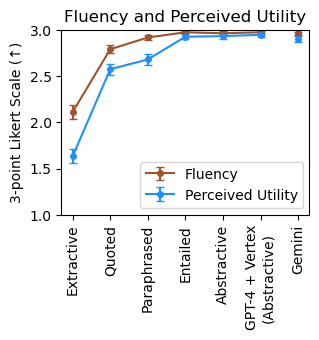

[([1.6334745762711864, 2.575, 2.68125, 2.9270833333333335, 2.933333333333333, 2.9479166666666665, 2.902083333333333], [0.07408133181548522, 0.060807675640832066, 0.05637786518679277, 0.027251687544442987, 0.025809088000710894, 0.02301352026393462, 0.031767180833774424])]


In [4]:
# Plot Utility and Fluency in aggregate
utilities = [get_avg_fluency_or_utility_by_op(all_results_df, 'human_utility_rating', ops)]
fluencies = [get_avg_fluency_or_utility_by_op(all_results_df, 'human_fluency_rating', ops)]

results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
def plot_utility_or_fluency(results_list, results_labels, fig, ax1, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        ax1.errorbar(op_names[:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
        ax1.errorbar(op_names[-1], averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[idx], capsize=3, ms=4)
        ax1.set_ylim([1,3])
    plt.xticks(rotation=90)
    return fig, ax1

fig, ax1 = plot_utility_or_fluency(fluencies, ['Fluency'], fig, ax1, colors=['sienna'])
fig, ax1 = plot_utility_or_fluency(utilities, ['Perceived Utility'], fig, ax1, colors=['dodgerblue'])
    
# Set labels and title
ax1.set_ylabel('3-point Likert Scale (↑)')

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(.29,0))

if (plot_pilot_results):
    plt.title('Pilot Fluency and Perceived Utility')
else:
    plt.title('Fluency and Perceived Utility')
plt.savefig('figures/utility_fluency_aggregate_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()
print(utilities)

In [5]:
print('Percent increase in utility from Extractive to GPT-4 + Vertex:', 100*(utilities[0][0][-2]-utilities[0][0][0])/(utilities[0][0][0]-1))

Percent increase in utility from Extractive to GPT-4 + Vertex: 207.49721293199553


## By dataset
### Utility

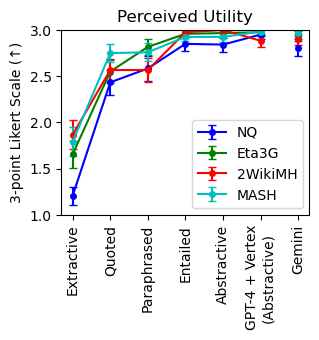

In [6]:
fluencies_or_utilities = []
for dataset in datasets:
    curr_fluency_or_utility = get_avg_fluency_or_utility_by_op(results[dataset], 'human_utility_rating', ops)
    fluencies_or_utilities.append(curr_fluency_or_utility)

results_list = fluencies_or_utilities
results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])

# Colors and markers
colors = ['b', 'g', 'r', 'c']
plot_utility_or_fluency(fluencies_or_utilities, label_datasets, fig, ax1, colors)

# Set labels and title
ax1.set_ylabel('3-point Likert Scale (↑)')

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(.5,0))

if (plot_pilot_results):
    plt.title('Pilot Perceived Utility')
else:
    plt.title('Perceived Utility')
plt.savefig('figures/utility_by_qd_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

### Fluency

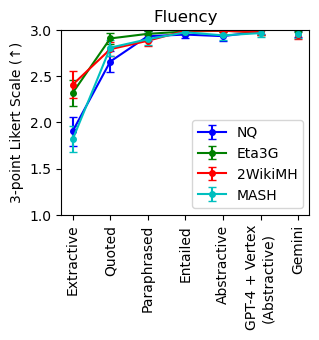

In [7]:
fluencies_or_utilities = []
for dataset in datasets:
    curr_fluency_or_utility = get_avg_fluency_or_utility_by_op(results[dataset], 'human_fluency_rating', ops)
    fluencies_or_utilities.append(curr_fluency_or_utility)

results_list = fluencies_or_utilities
results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])

# Colors and markers
colors = ['b', 'g', 'r', 'c']
plot_utility_or_fluency(fluencies_or_utilities, label_datasets, fig, ax1, colors)

# Set labels and title
ax1.set_ylabel('3-point Likert Scale (↑)')

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(.5,0))

if (plot_pilot_results):
    plt.title('Pilot Fluency')
else:
    plt.title('Fluency')
plt.savefig('figures/fluency_by_qd_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

# Precision and Coverage
## In aggregate

[([1, 0.9901140684410646, 0.9670658682634731, 0.9705240174672489, 0.9600798403193613, 0.8196392785571143, 0.8290816326530612], [0, 0.005349458271970674, 0.009573408161951485, 0.010959299943063642, 0.012127990351111943, 0.019483754005299114, 0.037313046339182414])]
[([1, 0.9029688631426502, 0.8881987577639752, 0.8518041237113402, 0.7618522601984564, 0.43369565217391304, 0.14988978692138133], [0, 0.015617390711765053, 0.017216512933237678, 0.02501457616273789, 0.027736431476529978, 0.032041718291201844, 0.01897187502637722])]


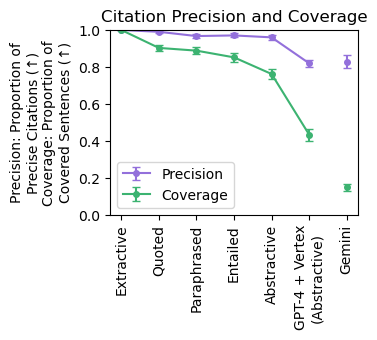

In [8]:
precisions = [get_avg_precision_by_op(all_results_df, ops[1:])]
coverages = [get_avg_coverage_by_op(all_results_df, ops[1:])]

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
print(precisions)
print(coverages)
fig, ax1 = plot_utility_or_fluency(precisions, ['Precision'], fig, ax1, colors=['mediumpurple'])
fig, ax1 = plot_utility_or_fluency(coverages, ['Coverage'], fig, ax1, colors=['mediumseagreen'])
    
# Set labels and title
ax1.set_ylabel('Precision: Proportion of\nPrecise Citations (↑)\nCoverage: Proportion of\nCovered Sentences (↑)')

if (plot_pilot_results):
    plt.title('Pilot Citation\nPrecision and Coverage')
else:
    plt.title('Citation Precision and Coverage')

plt.ylim(0,1)

# set the legend
lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,0))

plt.savefig('figures/precision_coverage_aggregate_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

In [9]:
print('Percent decrease in coverage from Extractive to GPT-4 + Vertex:', 100*(coverages[0][0][0]-coverages[0][0][-2])/(coverages[0][0][0]))

Percent decrease in coverage from Extractive to GPT-4 + Vertex: 56.630434782608695


In [10]:
print('Percent decrease in coverage between Entailed and Gemini:', 100*(coverages[0][0][3]-coverages[0][0][-1])/(coverages[0][0][3]))

Percent decrease in coverage between Entailed and Gemini: 82.40325648245205


## By dataset
### Precision

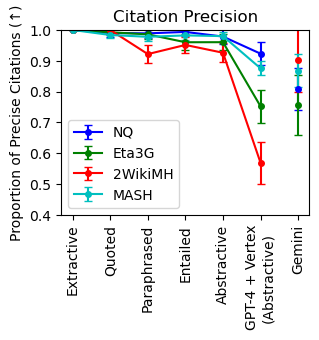

In [11]:
precisions = []
for dataset in datasets:
    precisions.append(get_avg_precision_by_op(results[dataset], ops[1:]))

results_list = precisions
results_labels = datasets

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])

# Colors and markers
colors = ['b', 'g', 'r', 'c']
plot_utility_or_fluency(precisions, label_datasets, fig, ax1, colors)

lines, labels = ax1.get_legend_handles_labels()
# Set labels and title
ax1.set_ylabel('Proportion of Precise Citations (↑)')

if (plot_pilot_results):
    plt.title('Pilot Citation Precision')
else:
    plt.title('Citation Precision')

plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,0))
plt.ylim(.4, 1)
plt.savefig('figures/precision_by_qd_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()

### Coverage

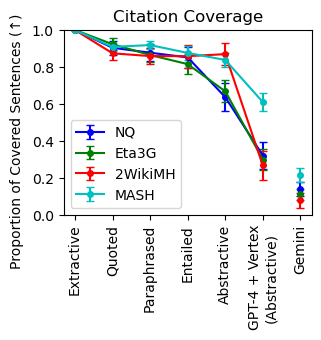

In [12]:
precisions = []
for dataset in datasets:
    precisions.append(get_avg_coverage_by_op(results[dataset], ops[1:]))

results_list = precisions
results_labels = datasets
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
# Colors and markers
colors = ['b', 'g', 'r', 'c']
plot_utility_or_fluency(precisions, label_datasets, fig, ax1, colors)

lines, labels = ax1.get_legend_handles_labels()
# Set labels and title
ax1.set_ylabel('Proportion of Covered Sentences (↑)')
ax1.yaxis.set_label_coords(-0.16,.4, transform=None)
if (plot_pilot_results):
    plt.title('Pilot Citation Coverage')
else:
    plt.title('Citation Coverage')

plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,0))
plt.ylim(0, 1)
plt.savefig('figures/coverage_by_qd_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()

# T2V

[([1.0, 1.4148340100350179, 1.6710357030583618, 1.789683960245353, 2.988290475949321, 2.28446786056097], [0.058427758910249136, 0.07544294255644059, 0.117646647282552, 0.1564111825656297, 0.25180992237350874, 0.19712437877097447])]


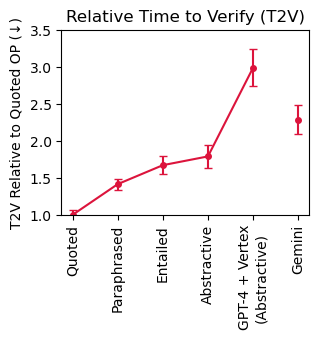

In [13]:
t2vs = []
op_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted')
new_avgs = op_t2vs[0][1:5]
new_errors = op_t2vs[1][1:5]
if (plot_pilot_results):
    baseline_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted')
else:
    baseline_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted Reeval')
new_avgs.extend(baseline_t2vs[0][-2:])
new_errors.extend(baseline_t2vs[1][-2:])
t2v = (new_avgs, new_errors)
t2vs.append(t2v)

def plot_t2v(results_list, results_labels, fig, ax1, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
        ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[idx], capsize=3, ms=4)
        ax1.set_ylim([1,3])
    plt.xticks(rotation=90)
    return fig, ax1
print(t2vs)
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, colors=['crimson'])


# Set labels and title
ax1.set_ylabel('T2V Relative to Quoted OP (↓)')
# ax1.set_xlabel('\nA') # if saving the appendix version

if (plot_pilot_results):
    plt.title('Pilot Relative Time to Verify (T2V)')
else:
    plt.title('Relative Time to Verify (T2V)')
    
plt.ylim(1,3.5)

plt.savefig('figures/t2v_aggregate_'+results_tag, bbox_inches='tight', dpi=400)
# plt.savefig('figures/t2v_aggregate_appendix_'+results_tag, bbox_inches='tight', dpi=400)


# Show the plot
plt.show()

In [14]:
print('GPT-4 + Vertex has this many times higher T2V than Quoted:', t2vs[0][0][-2])

GPT-4 + Vertex has this many times higher T2V than Quoted: 2.988290475949321


/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theod

[([1.0, 1.4797318300014057, 1.496732026372273, 2.107765528111028, 3.2796578648505665, 2.6678617165587677], [0.09670360553192088, 0.16934006010035232, 0.18385592538863363, 0.3758042808537618, 0.49183480892375536, 0.33367128359799064]), ([1.0, 1.5887120038231357, 1.7017714225339535, 1.8137643906130052, 3.456037434109524, 2.058724814298558], [0.09875123278302281, 0.15461001992329784, 0.24107026613070037, 0.32462212524424555, 0.5660530044328814, 0.329954463037017]), ([1.0, 1.6441666667634407, 1.9834680754952396, 2.190382317476617, 3.6153139021583485, 2.560541159167988], [0.11675976049709189, 0.2235755422353721, 0.3380125861250357, 0.5200657974148926, 0.854519750806497, 0.5519641931579166]), ([1.0, 1.272162682923897, 1.710854300180425, 1.714797266742078, 2.8484996866824845, 2.0417389639492307], [0.07738093163808701, 0.08990629359766383, 0.18704165705012088, 0.1694135026236401, 0.29503330216031487, 0.33523412798007857])]


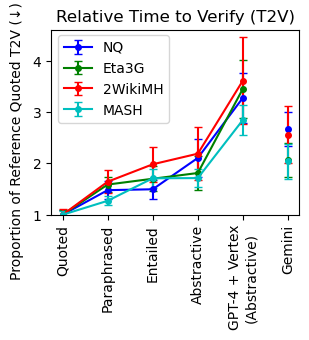

In [15]:
t2vs = []
for dataset in datasets:
    op_t2vs = get_relative_t2v_by_op(results[dataset], ops[1:], 'Quoted')
    new_avgs = op_t2vs[0][1:5]
    new_errors = op_t2vs[1][1:5]
    baseline_t2vs = get_relative_t2v_by_op(results[dataset], ops[1:], 'Quoted Reeval')
    new_avgs.extend(baseline_t2vs[0][-2:])
    new_errors.extend(baseline_t2vs[1][-2:])
    t2v = (new_avgs, new_errors)
    t2vs.append(t2v)

results_list = t2vs
results_labels = datasets
print(t2vs)
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
fig, ax1 = plot_t2v(t2vs, label_datasets, fig, ax1, colors)
    
plt.ylim(1,4.6)


# Set labels and title
ax1.set_ylabel('Proportion of Reference Quoted T2V (↓)')
ax1.yaxis.set_label_coords(-0.11,.4, transform=None)
if (plot_pilot_results):
    plt.title('Pilot Relative Time to Verify (T2V)')
else:
    plt.title('Relative Time to Verify (T2V)')

lines, labels = ax1.get_legend_handles_labels()
plt.legend(lines, labels, loc='lower left', bbox_to_anchor=(0,.46))
plt.savefig('figures/t2v_by_qd_'+results_tag, bbox_inches='tight', dpi=400)
# Show the plot
plt.show()

## T2V Median Values

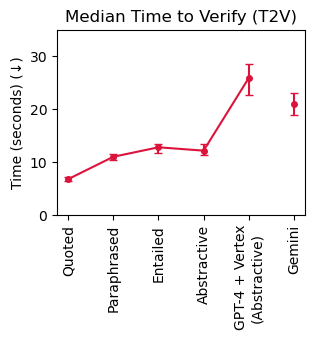

In [16]:
op_t2vs = get_median_t2v_by_op(all_results_df, ops[1:], normalized=False, remove_outliers=False, coverage_value=-1)
new_avgs = op_t2vs[0][1:7]
new_errors = op_t2vs[1][:,1:7]
t2vs = (new_avgs, new_errors)

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
lines, labels = ax1.get_legend_handles_labels()
ax1.errorbar(op_names[1:-1], t2vs[0][:-1], yerr=[t2vs[1][0][:-1],t2vs[1][1][:-1]], fmt='o-', color='crimson', label='T2V', capsize=3, ms=4)
ax1.errorbar('Gemini', t2vs[0][-1:], yerr=[t2vs[1][0][-1:],t2vs[1][0][-1:]], fmt='o-', color='crimson', capsize=3, ms=4)
ax1.set_ylim([0,35])
plt.xticks(rotation=90)

# Set labels and title
ax1.set_ylabel('Time (seconds) (↓)')

if (plot_pilot_results):
    plt.title('Pilot Median Time to Verify (T2V)')
else:
    plt.title('Median Time to Verify (T2V)')

plt.savefig('figures/t2v_median_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

## T2V Average Values

([12.667928542158602, 17.728752962173708, 21.105236884761364, 21.842515160847295, 37.62435740664997, 29.477828444875016], [1.1035833495618184, 1.1507686573330407, 1.9299143912874075, 2.0478082122673813, 3.079795560340135, 2.808706380314257])


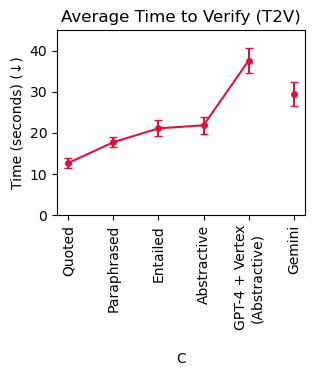

In [17]:
op_t2vs = get_avg_t2v_by_op(all_results_df, ops[1:], normalized=False, remove_outliers=False, coverage_value=-1)
new_avgs = op_t2vs[0][1:7]
new_errors = op_t2vs[1][1:7]
t2vs = (new_avgs, new_errors)

# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
lines, labels = ax1.get_legend_handles_labels()
ax1.errorbar(op_names[1:-1], t2vs[0][:-1], yerr=t2vs[1][:-1], fmt='o-', color='crimson', label='T2V', capsize=3, ms=4)
ax1.errorbar('Gemini', t2vs[0][-1:], yerr=t2vs[1][-1:], fmt='o-', color='crimson', capsize=3, ms=4)
ax1.set_ylim([0,45])
plt.xticks(rotation=90)

# Set labels and title
ax1.set_xlabel('\nC')
ax1.set_ylabel('Time (seconds) (↓)')

if (plot_pilot_results):
    plt.title('Pilot Average Time to Verify (T2V)')
else:
    plt.title('Average Time to Verify (T2V)')

plt.savefig('figures/t2v_average_'+results_tag, bbox_inches='tight', dpi=400)
print(t2vs)
plt.show()

# T2V for correctly covered sentences

In [18]:
all_results_df, results = load_all_mturk_results(needs_citation_only=True)

/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[([1.0, 1.351097414357922, 1.5813207834999392, 1.6791775204387684, 2.641569853542366, 1.9582457048840916], [0.059019557694535686, 0.07329449121941535, 0.12121717187554146, 0.17238479266261367, 0.22107912642244248, 0.24428490245407347])]


/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


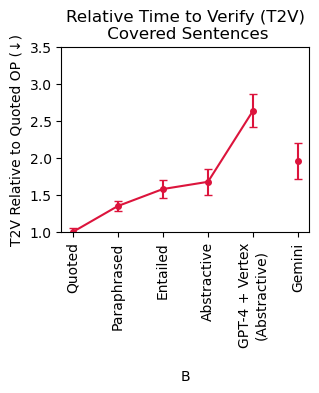

In [19]:
t2vs = []
op_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted', coverage_value=1)
new_avgs = op_t2vs[0][1:5]
new_errors = op_t2vs[1][1:5]
baseline_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted Reeval', coverage_value=1)
new_avgs.extend(baseline_t2vs[0][-2:])
new_errors.extend(baseline_t2vs[1][-2:])
t2v = (new_avgs, new_errors)
t2vs.append(t2v)

def plot_t2v(results_list, results_labels, fig, ax1, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[idx], label=result_label, capsize=3, ms=4)
        ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[idx], capsize=3, ms=4)
        ax1.set_ylim([1,3])
    plt.xticks(rotation=90)
    return fig, ax1
print(t2vs)
# Initialize the plot
fig, ax1 = plt.subplots()
fig.set_size_inches([3.2, 2.4])
fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, colors=['crimson'])
    
# Set labels and title
ax1.set_xlabel('\nB')
ax1.set_ylabel('T2V Relative to Quoted OP (↓)')

plt.title('Relative Time to Verify (T2V)\n Covered Sentences')
plt.ylim(1,3.5)

# no legend

plt.savefig('figures/t2v_aggregate_covered_only_'+results_tag, bbox_inches='tight', dpi=400)

# Show the plot
plt.show()

In [20]:
def t2v_and_coverage_consistency(all_results_df, tag=''):
    for i in range(len(all_results_df)):
        if (all_results_df['op'].iloc[i] == 'Snippet'):
            continue
        coverage = eval(all_results_df['is_covered'].iloc[i])
        t2v = eval(all_results_df['t2v_coverage'].iloc[i])
        num_nonneg_cov = len([x for x in coverage if x['coverage']!=-1])
        if (len(t2v) != num_nonneg_cov):
            print(tag)
            print('num T2V annotations', len(t2v))
            print('num coverage annotations', len(coverage))
            print('T2V annotations', t2v)
            print('Coverage annotations', coverage)
            print()
t2v_and_coverage_consistency(all_results_df)

# T2V over full responses

[([1.0, 1.4920386647648043, 1.0823097240740682, 1.2614156792075584, 2.009389848448843, 1.8427780816518973], [0.0869451033512649, 0.14395663836965006, 0.09173287702485258, 0.13619289191241138, 0.24816581130867307, 0.34653877757296403])]


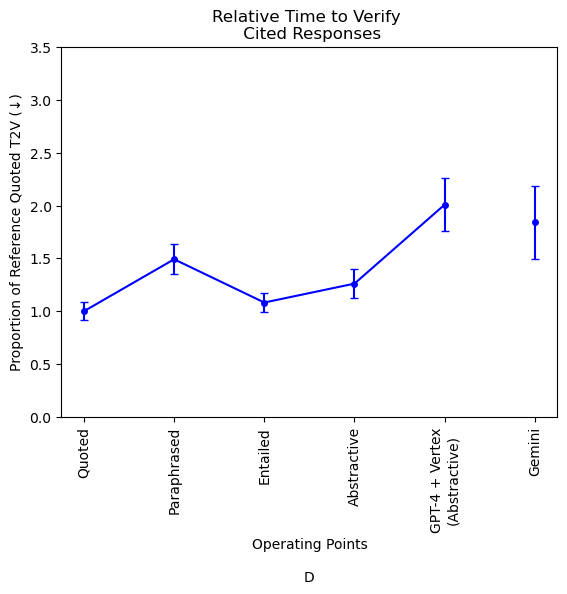

In [21]:
fig, ax1 = plt.subplots()

t2vs = []
op_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted', over_response=True, coverage_value=1)
new_avgs = op_t2vs[0][1:5]
new_errors = op_t2vs[1][1:5]
baseline_t2vs = get_relative_t2v_by_op(all_results_df, ops[1:], 'Quoted Reeval', over_response=True, coverage_value=1)
new_avgs.extend(baseline_t2vs[0][-2:])
new_errors.extend(baseline_t2vs[1][-2:])
t2v = (new_avgs, new_errors)
t2vs.append(t2v)

def plot_t2v(results_list, results_labels, fig, ax1, num_sentences, colors):    
    # Plot the first set of results
    lines, labels = ax1.get_legend_handles_labels()
    for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
        result_label = nested_tuple[1]
        averages = nested_tuple[0][0]
        conf_intervals = nested_tuple[0][1]
        marker = 'o'
        ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4)
        ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4)
        ax1.set_ylim([0,2.5])
    plt.xticks(rotation=90)
    return fig, ax1
print(t2vs)

fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, 1, colors=colors)
    
# Set labels and title
ax1.set_xlabel('Operating Points\n\nD')
ax1.set_ylabel('Proportion of Reference Quoted T2V (↓)')

plt.title('Relative Time to Verify \n Cited Responses')
plt.ylim(0,3.5)

plt.savefig('figures/t2v_aggregate_entire_response_by_sentence_'+results_tag, bbox_inches='tight', dpi=400)

plt.show()

### Evaluate relative T2V over entire responses QD

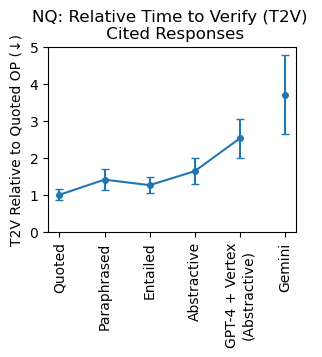

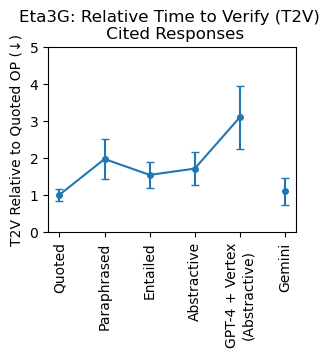

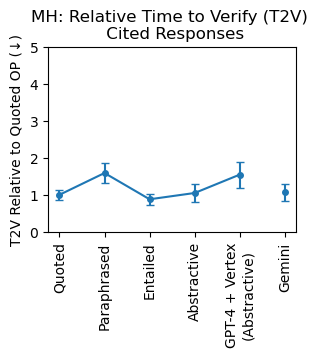

/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/theodoraworledge/miniconda3/envs/attrib/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


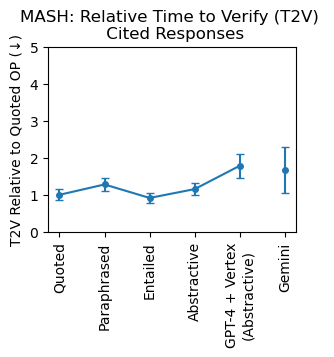

In [22]:
def plot_t2v(results_list, results_labels, fig, ax1, num_sentences, colors):    
            # Plot the first set of results
            lines, labels = ax1.get_legend_handles_labels()
            for idx, nested_tuple in enumerate(zip(results_list, results_labels)):
                result_label = nested_tuple[1]
                averages = nested_tuple[0][0]
                conf_intervals = nested_tuple[0][1]
                marker = 'o'
                ax1.errorbar(op_names[1:-1], averages[:-1], yerr=conf_intervals[:-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4)
                ax1.errorbar('Gemini', averages[-1], yerr=conf_intervals[-1], fmt=marker + '-', color=colors[num_sentences-1], capsize=3, ms=4)
                ax1.set_ylim([0,5])
            return fig, ax1
data_i = 0
for i in range(2):
    for j in range(2):
        fig, ax1 = plt.subplots(figsize=(3.2, 2.4))
        data_str = datasets[data_i]
        data_i += 1
        colors = ['tab:blue', 'tab:orange', 'black']
        t2vs = []
        op_t2vs = get_relative_t2v_by_op(results[data_str], ops[1:], 'Quoted', over_response=True, coverage_value=1)
        new_avgs = op_t2vs[0][1:5]
        new_errors = op_t2vs[1][1:5]
        baseline_t2vs = get_relative_t2v_by_op(results[data_str], ops[1:], 'Quoted Reeval', over_response=True, coverage_value=1)
        new_avgs.extend(baseline_t2vs[0][-2:])
        new_errors.extend(baseline_t2vs[1][-2:])
        t2v = (new_avgs, new_errors)
        t2vs.append(t2v)
        
        # Initialize the plot
        fig, ax1 = plot_t2v(t2vs, ['T2V'], fig, ax1, 1, colors=colors)
            
        # Set labels and title
        ax1.set_ylabel('T2V Relative to Quoted OP (↓)')
        
        plt.title(data_str+': Relative Time to Verify (T2V) \n Cited Responses')
        plt.xticks(rotation=90)
        plt.savefig('figures/t2v_'+data_str+'_entire_covered_response_'+results_tag, bbox_inches='tight', dpi=400)
        plt.show()


# Average Quote Length

In [23]:
def count_quoted_words_and_quotes(quoted_output):
    quotes = re.findall(r'"(.*?)"', quoted_output)
    quoted_words = [len(q.split(' ')) for q in quotes]
    quoted_characters = [len(q) for q in quotes]
    total_words = len(quoted_output.split(' '))
    return quoted_words, quoted_characters, len(quotes), total_words

In [24]:
quoted_outputs = all_results_df[all_results_df['op']=='Quoted']['Output (cited)']
total_quoted_words = []
total_quoted_characters = []
total_words = 0
n_quotes = 0
for i in range(len(quoted_outputs)):
    curr_total_quoted_words, curr_total_quoted_characters, curr_n_quotes, curr_total_words = count_quoted_words_and_quotes(quoted_outputs.iloc[i])
    total_quoted_words += curr_total_quoted_words # appending to a list
    n_quotes += curr_n_quotes # adding to a sum
    total_quoted_characters += curr_total_quoted_characters # appending to a list
    total_words += curr_total_words # appending to a list

In [25]:
print(np.sum(total_quoted_words)/n_quotes, 'words')

14.5438919582566 words


In [26]:
print(np.sum(total_quoted_characters)/n_quotes, 'characters')

84.64333947206876 characters


In [27]:
print(np.sum(total_quoted_words)/total_words*100,'% quoted')

81.74165056582943 % quoted


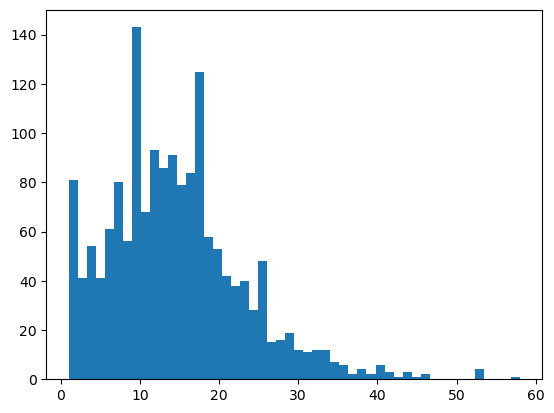

In [28]:
plt.hist(total_quoted_words, 50);

# Avg output length in words by OP

In [29]:
def clean_highlight_markers_from_snippets(df):
    df = df.copy()
    for i in range(len(df)):
        response = df['Output'].iloc[i]
        colors = {'\\x1b[92m':':green[', '\\x1b[96m':':orange[', '\\x1b[95m':':red[', '\\x1b[1;31;60m':':blue[', '\\x1b[102m':':violet[', '\x1b[1;35;40m':':grey[', '\\x1b[0;30;47m':':rainbow[', '\\x1b[0;33;47m':':orange[', '\\x1b[0;34;47m':':blue[', '\\x1b[0;31;47m':':red[', '\\x1b[0m':']'}
        for highlight_marker in colors.keys():
            response_ls = response.split(highlight_marker)
            response = ''.join(response_ls)
        df.loc[i, 'Output'] = response
    return df

In [30]:
for op in ops:
    op_results_df = all_results_df[all_results_df['op']==op]
    if (op=='Snippet'):
        op_results_df = clean_highlight_markers_from_snippets(op_results_df)
    
    output_lengths = op_results_df['Output'].str.split().apply(len)
    print(op+':', np.mean(output_lengths))

Snippet: 235.75833333333333
Quoted: 56.985416666666666
Paraphrased: 60.15625
Entailed: 32.72291666666667
Abstractive: 38.475
Post Hoc: 34.49166666666667
Gemini: 47.829166666666666
